In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
from fiona.crs import from_epsg

In [2]:
import urllib, json, requests 
import geojson

In [3]:
from ipyleaflet import Map, GeoData, GeoJSON, basemaps, basemap_to_tiles, Icon, Circle, Marker, LayerGroup, WidgetControl
import ipywidgets as widgets
from ipywidgets import Button 
from IPython.display import display, clear_output

In [4]:
#drawing basic map
center = (40.7210907,-73.9877836)
basemap = basemap_to_tiles(basemaps.CartoDB.Positron)

#variables for half-mi buffer
radius = 402 #in-meters
color = "black"
fill_color = "#000000"
fill_opacity = .2
opacity = 1
weight = 2
title = "Test"
###########

circle = Circle()
circle.location = center
circle.opacity = 0
circle.radius=radius

draggable=False
marker_opacity=1
icon = Icon(icon_url='icon.png', icon_size=[15, 15])
marker = Marker(location=center, draggable=draggable, icon=icon, opacity=marker_opacity)

m = Map(layers=(basemap, ), center=center, zoom=15, min_zoom = 7, max_zoom = 20)

layer_group = LayerGroup(layers=(marker, circle))
m.add_layer(layer_group)

button = Button(description="Generate Text")
output = widgets.Output()

widget_control = WidgetControl(widget=button, position='topright')
m.add_control(widget_control)

In [5]:
def draw_buffer_original():
    layer_group.clear_layers();
    layer_group.add_layer(marker)

    df2 = pd.DataFrame(marker.location)
    df=df2.transpose()
    df.columns=['Latitude','Longitude']

    #creating a geodataframe from the point
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

    # making buffer circle from point 
    test=gdf.copy()
    test['geometry'] = test.geometry.buffer(.004,  cap_style=1, join_style=1)

    #Make vector that covers the entirety of base map extent 
    #calculate difference with the circle 
    #then you have the highlighted map
    rect =gdf.copy()
    rect['geometry'] = rect.buffer(1,  cap_style=1, join_style=1)

    diff = gpd.overlay(rect, test, how='difference')

    geo_data = GeoData(geo_dataframe = diff,
                       style={'color': color, \
                              'fillColor': fill_color, \
                              'fillOpacity': fill_opacity, \
                              'opacity': opacity, \
                              'weight': weight},
                       name = title)

    layer_group.add_layer(geo_data);

draw_buffer_original()

In [6]:
##click on map to add marker, removes old marker as well
def handle_click(**kwargs):
    if kwargs.get('type') == 'click':
        layer_group.clear_layers();
        marker = Marker(location=kwargs.get('coordinates'), draggable=draggable, icon=icon, opacity=marker_opacity)
        layer_group.add_layer(marker)
        
        draw_buffer(**kwargs)

In [7]:
# def on_location_changed(event):
#     layer_group.clear_layers();
#     marker = Marker(location=kwargs.get('coordinates'), draggable=draggable, icon=icon, opacity=marker_opacity)
#     markerlocation = marker.location
#     layer_group.add_layer(marker);
    
#     draw_buffer(**kwargs)
#     m.on_interaction(handle_click)
    
#     pass

# marker.observe(on_location_changed, 'location')

In [8]:
def draw_buffer(**kwargs):
    layer_group.clear_layers();
    marker = Marker(location=kwargs.get('coordinates'), draggable=draggable, icon=icon, opacity=marker_opacity)
    layer_group.add_layer(marker)

    #extracting the marker location for the buffer
    df2 = pd.DataFrame(marker.location)
    df=df2.transpose()
    df.columns=['Latitude','Longitude']

    #creating a geodataframe from the point
    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

    # making buffer circle from point 
    test=gdf.copy()
    test['geometry'] = test.geometry.buffer(.004,  cap_style=1, join_style=1)

    #Make vector that covers the entirety of base map extent 
    #calculate difference with the circle 
    #then you have the highlighted map
    rect =gdf.copy()
    rect['geometry'] = rect.buffer(1,  cap_style=1, join_style=1)

    diff = gpd.overlay(rect, test, how='difference')

    geo_data = GeoData(geo_dataframe = diff,
                       style={'color': color, \
                              'fillColor': fill_color, \
                              'fillOpacity': fill_opacity, \
                              'opacity': opacity, \
                              'weight': weight},
    #                    hover_style={'fillColor': 'red' , \
    #                                 'fillOpacity': 0.2},
                       name = title)

    layer_group.add_layer(geo_data);

In [9]:
def find_location():
    #Extracting latitude and longitude values as separate strings from marker location ie from center
    markerlocation = marker.location 

    lat = str(markerlocation[0])
    lon = str(markerlocation[1])
#     print(lat,'+', lon)

    #Figure out which state and census block a latitude/longitude is in

    #Contruct request URL
    url = f'https://geo.fcc.gov/api/census/block/find?'

    # api call using variables instead of directly is way easier
    data_url = f'{url}lat={lat}&lon={lon}&format=json'
    #Get response from API
    response=requests.get(data_url)

    #Parse json in response
    data = response.json()
#     print(response.text)

    #Extracting the county and state being studied 
    state = data['results'][0]['state_fips']
    county_fips = data['results'][0]['county_fips']

    #Separating out the county fips from the state
    county = county_fips[2:]

#     print(state, county)
    
    return state, county

In [10]:
def download_acs():  
    api_key = '9330dc4bf086a84f19fb412bb15f232507301de6'
    acs_url = f'https://api.census.gov/data/2018/acs/acs5/'

    pop_sex = 'B01003_001E,B01001_002E,B01001_026E'
    household_type = 'B11001_002E,B11001_007E'
    education = 'B15003_001E,B15003_017E,B15003_018E,B15003_019E,B15003_020E,B15003_021E,B15003_022E,B15003_023E,B15003_024E,B15003_025E'
    household_income = 'B19001_002E,B19001_003E,B19001_004E,B19001_005E,B19001_006E,B19001_007E,B19001_008E,B19001_009E,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B19001_014E,B19001_015E,B19001_016E,B19001_017E'
    means_of_transport = 'B08301_002E,B08301_003E,B08301_003E,B08301_010E,B08301_016E,B08301_017E,B08301_018E,B08301_019E,B08301_020E,B08301_021E'
    travel_time = 'B08303_002E,B08303_003E,B08303_004E,B08303_005E,B08303_006E,B08303_007E,B08303_008E,B08303_009E,B08303_010E,B08303_011E,B08303_012E,B08303_013E'

    # api call using variables instead of directly is way easier
    pop_sex_url = f'{acs_url}?&get={pop_sex}&for=tract:*&in=state:{state}%20county:*&key={api_key}'
    household_type_url = f'{acs_url}?&get={household_type}&for=tract:*&in=state:{state}%20county:*&key={api_key}'
    education_url = f'{acs_url}?&get={education}&for=tract:*&in=state:{state}%20county:*&key={api_key}'
    household_income_url = f'{acs_url}?&get={household_income}&for=tract:*&in=state:{state}%20county:*&key={api_key}'
    means_of_transport_url = f'{acs_url}?&get={means_of_transport}&for=tract:*&in=state:{state}%20county:*&key={api_key}'
    travel_time_url = f'{acs_url}?&get={travel_time}&for=tract:*&in=state:{state}%20county:*&key={api_key}'

    #load the response into a JSON
    data_acs1=requests.get(pop_sex_url).json()
    data_acs2=requests.get(household_type_url).json()
    data_acs3=requests.get(education_url).json()
    data_acs4=requests.get(household_income_url).json()
    data_acs5=requests.get(means_of_transport_url).json()
    data_acs6=requests.get(travel_time_url).json()
    # print(response_acs.text)

    #ignoring the first element which is column names, replacing columns with the columns from the table
    acs1=pd.DataFrame(data_acs1[1:], columns=data_acs1[0])
    acs2=pd.DataFrame(data_acs2[1:], columns=data_acs2[0])
    acs3=pd.DataFrame(data_acs3[1:], columns=data_acs3[0])
    acs4=pd.DataFrame(data_acs4[1:], columns=data_acs4[0])
    acs5=pd.DataFrame(data_acs5[1:], columns=data_acs5[0])
    acs6=pd.DataFrame(data_acs6[1:], columns=data_acs6[0])
    
    return acs1, acs2, acs3, acs4, acs5, acs6

In [11]:
def clean_acs():

SyntaxError: unexpected EOF while parsing (<ipython-input-11-3908245a8c71>, line 1)

In [25]:
def import_censustracts():
    global location_query, location_string, state_val, county_val
    state_val = str(state)
    county_val = str(county)
    
    location_string = 'STATE=state AND COUNTY=county'
    location_query = location_string.replace('state', state_val).replace('county', county_val)

    # census tracts link
    endpoint = 'https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Tracts_Blocks/MapServer/4/query'
    s = requests.session()
    s.params = {
        'where': location_query,
        'text': '',
        'objectIds': '',
        'time': '',
        'geometry': '[[-2336502.536,-20037700.],[1.1615796196E7,2.0656504635E7]]',
        'geometryType': 'esriGeometryEnvelope',
        'inSR': 102100, # EPSG 3857
        'spatialRel': 'esriSpatialRelIntersects',
        'relationParam': '',
    #specify fields
        'outFields': 'GEOID,STATE,COUNTY,TRACT,STGEOMETRY, OBJECTID',
        'returnGeometry': True,
        'returnTrueCurves': False,
        'maxAllowableOffset': '',
        'geometryPrecision': '',
        'outSR': '',
        'returnIdsOnly': False,
        'returnCountOnly': False,
        'orderByFields': '',
        'groupByFieldsForStatistics': '',
        'outStatistics': '',
        'returnZ': False,
        'returnM': False,
        'gdbVersion': '',
        'returnDistinctValues': False,
        'f': 'geojson',        
    }
    start = 0
    done = False
    features = []
    crs = None
    while not done:
        r = s.get(endpoint, params={
            'resultOffset': start,
            'resultRecordCount': 32,
        })
        r.raise_for_status()
        tracts = geojson.loads(r.text)
        newfeats = tracts.__geo_interface__['features']
        if newfeats:
            features.extend(newfeats)
            crs=tracts.__geo_interface__['crs']
            start += len(newfeats)
            print("Received", len(newfeats), "entries,", start, "total")
        else:
            done = True
            
    tracts_df = gpd.GeoDataFrame.from_features(features, crs='epsg:4326')
    
    return tracts_df

In [ ]:
def join_acs():

In [ ]:
def proportional_split():

In [ ]:
def aggregate():

In [ ]:
def summary_stats():

In [ ]:
#CHARTS!!! comes after cleaning the data and before buttons

In [ ]:
def generate_text():

In [26]:
display(button, output)

def on_button_clicked(b):
    output.clear_output()
    
    global state, county
    state, county = find_location()
    
    global acs1, acs2, acs3, acs4, acs5, acs6
    acs1, acs2, acs3, acs4, acs5, acs6 = download_acs()
    
    global tracts_df
    tracts_df = import_censustracts()
    
    with output:
        print("Button clicked.")

button.on_click(on_button_clicked)

Button(description='Generate Text', style=ButtonStyle())

Output(outputs=({'output_type': 'stream', 'text': 'Button clicked.\n', 'name': 'stdout'},))

Received 32 entries, 32 total
Received 32 entries, 64 total
Received 32 entries, 96 total
Received 32 entries, 128 total
Received 32 entries, 160 total
Received 32 entries, 192 total
Received 32 entries, 224 total
Received 32 entries, 256 total
Received 32 entries, 288 total
Received 32 entries, 32 total
Received 32 entries, 64 total
Received 32 entries, 96 total
Received 32 entries, 128 total
Received 32 entries, 160 total
Received 32 entries, 192 total
Received 32 entries, 224 total
Received 32 entries, 256 total
Received 32 entries, 288 total
Received 32 entries, 32 total
Received 32 entries, 64 total
Received 32 entries, 96 total
Received 32 entries, 128 total
Received 32 entries, 160 total
Received 32 entries, 192 total
Received 32 entries, 224 total
Received 32 entries, 256 total
Received 32 entries, 288 total
Received 32 entries, 32 total
Received 32 entries, 64 total
Received 32 entries, 96 total
Received 32 entries, 128 total
Received 32 entries, 160 total
Received 32 entries,

In [ ]:
# button.on_click(on_button_clicked)
m.on_interaction(handle_click)
# marker.observe(on_location_changed, 'location')
    
m

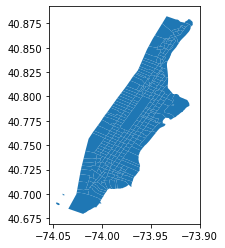

In [27]:
tracts_df.plot()

In [ ]:
from shapely.geometry import Polygon
import geopandas as gpd
import pandas as pd
import numpy as np
import requests

def get_geography(geoid):
    # https://api.censusreporter.org/1.0/geo/tiger2016/16000US5367000?geom=true

    api_url = 'https://api.censusreporter.org/1.0/geo/tiger2016/{0}?geom=true'
    data = requests.get(api_url.format(geoid)).json()


    # Get Features
    fdf = pd.DataFrame({
                        'Geoid': geoid,
                        'LandArea': data['properties']['aland'] / 2589988,
                        'Population': data['properties']['population']
                        }, index=[0])
    fdf['PopulationDensity'] = fdf.Population / fdf.LandArea

    # Convert Points into Geopandas Geometry
    numpy_points =   np.array(data['geometry']['coordinates'][0])
    fdf['Geometry'] = Polygon(numpy_points)

    return gpd.GeoDataFrame(fdf, crs='epsg:4326', geometry = 'Geometry')

get_geography('86000US78666').plot()

In [ ]:
# #drawing basic map
# center = (40.7210907,-73.9877836)
# basemap = basemap_to_tiles(basemaps.CartoDB.Positron)

# icon = Icon(icon_url='icon.png', icon_size=[15, 15])
# marker = Marker(location=center, draggable=False, icon=icon, opacity = 0.8)

# m = Map(layers=(basemap, ), center=center, zoom=15, min_zoom = 11, max_zoom = 20, ax=ax, fig=fig)

# ###HALF-MI BUFFER
# #set location of center as location of the point
# markerlocation=marker.location
# print(markerlocation)
    
# radius = 402 #in-meters
# color = "black"
# fill_color = "white"
# fill_opacity = .2
# weight = 2

# ##click on map to add marker, removes old marker as well
# def handle_click(**kwargs):
#     if kwargs.get('type') == 'click':
#         layer_group.clear_layers();
#         marker = Marker(location=kwargs.get('coordinates'), draggable=False, icon=icon, opacity = 0.8)
#         layer_group.add_layer(marker)
        
#         #updating the circle's location
#         markerlocation=marker.location
#         circle.location = markerlocation
#         layer_group.add_layer(circle);
        
# m.on_interaction(handle_click)
# ######

# #create half-mi buffer
# circle = Circle()
# circle.location = markerlocation
# circle.radius = radius
# circle.color = color
# circle.fill_color = fill_color
# circle.fill_opacity = fill_opacity
# circle.weight = weight
# ###########

    
# # def on_location_changed(event):
# # #remove any circles existing first
# #     layer_group.clear_layers();

# # #update location of center as location of the point
# #     markerlocation = marker.location
# #     circle.location = markerlocation
# #     layer_group.add_layer(circle);
        
# # pass
# # marker.observe(on_location_changed, 'location')
# # #######


# # #adding button that performs the analysis on click 
# # button = Button(description="Reset")

# # def on_button_clicked(b, geo_json):   
    
# # button.on_click(on_button_clicked)

    
# # widget_control = WidgetControl(widget=button, position='topright')
# # m.add_control(widget_control)

# m.add_control(LayersControl())

# layer_group = LayerGroup(layers=(marker, circle))
# m.add_layer(layer_group)

# # display(m)